# Libraries

In [22]:
# Import libraries

from os import listdir
import string
import pandas as pd
import numpy as np  
import pandas as pd 
import re           
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords   
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings
import re, string, unicodedata
import contractions
import nltk
import pickle
import inflect
from bs4 import BeautifulSoup
import tensorflow as tf
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer
lemmatizer = WordNetLemmatizer() 

pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

In [23]:
if tf.test.gpu_device_name(): 
    print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))
else:
   print("Please install GPU version of TF")

Default GPU Device:/device:GPU:0


# Loading data

In [24]:
# load doc into memory
def load_doc(filename):
	file = open(filename, encoding='utf-8')
	text = file.read()
	file.close()
	return text

# split a document into news story and highlights
def split_story(doc):
	# find first highlight
	index = doc.find('@highlight')
	# split into story and highlights
	story, highlights = doc[:index], doc[index:].split('@highlight')
	# strip extra white space around each highlight
	highlights = [h.strip() for h in highlights if len(h) > 0]
	return story, highlights

# load all stories in a directory
def load_stories(directory):
    stories = []
    highlights =[]
    for name in listdir(directory)[12000:14001]:
        filename = directory + '/' + name
		# load document
        doc = load_doc(filename)
		# split into story and highlights
        story, highlight = split_story(doc)
		# store
        stories.append(story)
        highlights.append(highlight)
    data = pd.DataFrame()
    data["story"] = stories
    data["highlight"] = highlights
    
    return  data

In [25]:
# load stories
directory = r"C:\Users\feder\Desktop\cnn\stories"
data = load_stories(directory)


In [26]:
print('Loaded Stories %d' % len(data))

Loaded Stories 2001


# Cleaning and preprocessing


In [27]:
data.head()

,story,highlight
0,"(CNN) -- Former first lady Barbara Bush will spend the night in a Houston, Texas, hospital Tuesday night after falling ill, according to a family spokeswoman.\n\nFormer first lady Barbara Bush has...","[NEW: Former first lady will spend the night in a Houston, Texas, hospital, NEW: ""She's fine,"" spokesman for Barbara Bush's husband says, Family spokeswoman: She complained recently about stomach ..."
1,"(CNN) -- Saying no one can can diminish what she and her team accomplished, a confident Diana Nyad took on her critics Wednesday night on ""Piers Morgan Live."" Her record-breaking Cuba to Florida s...","[Diana Nyad completed the 110-mile swim from Cuba to Florida last week, She says she is the first person to do it unassisted and without a shark cage, But many questions have been raised about asp..."
2,"(CNN)Each day, CNN producers select a user-submitted photo to be our Travel Photo of the Day. Click through the gallery above to see stunning shots from around the world, and be sure to come back ...","[See more iReport galleries: Glorious Ireland, beautiful beaches, Follow us on Twitter @cnnireport and @CNNTravel]"
3,"(CNN) -- Unbeknownst to her parents, Sydney Kirk tried a little medical experiment on herself when she was in the eighth grade. For a day or two, every so often, she stopped taking her drugs for h...","[The CDC estimates 4.5 million children and teens have ADHD, Expert: ""Drugs are viewed as the frontline treatment"", Behavioral treatments can also be effective over the long run, If patient decide..."
4,Tokyo (CNN) -- Authorities have suspended their search for a missing crew member in a U.S. military helicopter that crashed in Okinawa after human remains were found at the site.\n\nThe helicopter...,"[Japan's prime minister calls for the grounding of the U.S. helicopters during an investigation, The helicopter crashed at a Marine base on Okinawa]"


In [28]:
data = data.explode("highlight")

In [29]:
data = data.drop_duplicates(subset="story")

## Normalization

In [30]:
stop_words = set(stopwords.words('english')) 

def remove_non_ascii(words):
    """Remove non-ASCII characters"""
    new_words = unicodedata.normalize('NFKD', words).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return new_words

def to_lowercase(words):
    """Convert all characters to lowercase"""
    new_words = words.lower()
    return new_words

def remove_punctuation(words):
    """Remove punctuation"""
    new_words = re.sub(r'\([^)]*\)', '', words)
    return new_words

def replace_numbers(words):
    """Replace all integer occurrences"""
    new_words = re.sub("[^a-zA-Z]", " ", words) 
    return new_words

def remove_stopwords(words):
    """Remove stop words"""
    new_words = [w for w in words.split() if not w in stop_words]
    long_words=[]
    for i in new_words:
        if len(i)>=1:                  
            long_words.append(i)   

    return (" ".join(long_words)).strip()


def replace_contractions(words):
    """Replace contractions in string of text"""
    return contractions.fix(words)

def normalize(words):
    words = remove_non_ascii(words)
    words = to_lowercase(words)
    words = remove_punctuation(words)
    words = replace_numbers(words)
    words = replace_contractions(words)
    words = remove_stopwords(words)

    return words

In [31]:
#Call the above function

cleaned_story = []
for t in data['story']:
    cleaned_story.append(normalize(t))

cleaned_highlight = []
for t in data['highlight']:
    cleaned_highlight.append(normalize(t))

data['normalized_text']=cleaned_story
data['normalized_highlight']=cleaned_highlight
data['normalized_highlight'].replace('', np.nan, inplace=True)
data.dropna(axis=0,inplace=True)

## Lemmatization

In [32]:
def lemmatize(words):
    words = lemmatizer.lemmatize(words)
    return words

In [33]:
#Call the above function

lemmatized_story = []
for t in data['normalized_text']:
    lemmatized_story.append(lemmatize(t))
    
lemmatized_highlight = []
for t in data['normalized_highlight']:
    lemmatized_highlight.append(lemmatize(t))

data['cleaned_text']=lemmatized_story
data['cleaned_highlight']=lemmatized_highlight
data['cleaned_highlight'].replace('', np.nan, inplace=True)
data.dropna(axis=0,inplace=True)

## Add start and end tokens for the summarizer

In [34]:
data['cleaned_highlight'] = data['cleaned_highlight'].apply(lambda x : 'starttoken '+ x + ' endtoken')


## Visualize results

In [35]:
data = data[["cleaned_text", "cleaned_highlight"]]
data

,cleaned_text,cleaned_highlight
0,former first lady barbara bush spend night houston texas hospital tuesday night falling ill according family spokeswoman former first lady barbara bush admitted houston texas hospital spokeswoman ...,starttoken new former first lady spend night houston texas hospital endtoken
1,saying one diminish team accomplished confident diana nyad took critics wednesday night piers morgan live record breaking cuba florida swin said book swam fair square squeaky clean across thing ny...,starttoken diana nyad completed mile swim cuba florida last week endtoken
2,day cnn producers select user submitted photo travel photo day click gallery see stunning shots around world sure come back every day new image gorgeous travel photo share submit gallery cnn ireport,starttoken see ireport galleries glorious ireland beautiful beaches endtoken
3,unbeknownst parents sydney kirk tried little medical experiment eighth grade day two every often stopped taking drugs attention deficit hyperactivity disorder sydney kirk right took medication vac...,starttoken cdc estimates million children teens adhd endtoken
4,tokyo authorities suspended search missing crew member military helicopter crashed okinawa human remains found site helicopter crashed monday camp hansen marine base japanese island three crew mem...,starttoken japan prime minister calls grounding helicopters investigation endtoken
...,...,...
1996,china li na set intriguing final defending champion victoria azarenka australian open comprehensive victory thursday world maria sharapova sixth seed beaten finalist imperious form romped win russ...,starttoken china li na beats russia maria sharapova straight sets reach final endtoken
1997,witch back course computer historian already know witch refers wolverhampton instrument teaching computation harwell story ton machine first constructed part atomic research program became world o...,starttoken world oldest original working digital computer gets reboot endtoken
1998,remnants tropical storm erin turned central oklahoma wash basin sunday rescuers helicopters plucking people flood waters rooftops ferrying safety flood victim hangs precariously rescue flight sund...,starttoken rains destroying homes stranding people oklahoma endtoken
1999,prop stylist elizabeth press traces gift wrapping prowess mother whose creative budget conscious ideas like wrapping boxes painted newspaper comics pasting gift certificates inside hollowed books ...,starttoken elizabeth press advises spelling recipient name initials alphabet stamps endtoken


In [36]:
data.to_csv("test_dataset.csv", index=False)

In [37]:
x_test = data['cleaned_text']
y_test = data['cleaned_highlight']

## Tokenization

In [38]:
#!pip install pickle5
import  pickle

In [39]:
def open_test_data_y():
    return open('../tokenizers_vars/y_tokenizer.pickle', 'rb')

with open_test_data_y() as f:
    y_tokenizer = pickle.load(f) 

def open_test_data_x():
    return open('../tokenizers_vars/x_tokenizer.pickle', 'rb')

with open_test_data_x() as f:
    x_tokenizer = pickle.load(f) 

In [40]:
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences


In [41]:
thresh=4

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in x_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 20.37335164184758
Total Coverage of rare words: 0.39457576608869416


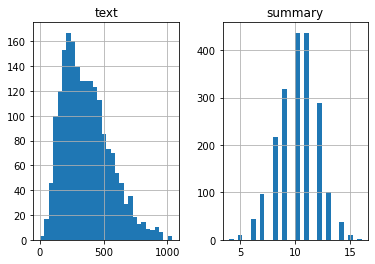

In [42]:

import matplotlib.pyplot as plt

text_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in data['cleaned_text']:
      text_word_count.append(len(i.split()))

for i in data['cleaned_highlight']:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})

length_df.hist(bins = 30)
plt.show()

In [43]:
cnt=0
for i in data['cleaned_highlight']:
    if(len(i.split())<=14):
        cnt=cnt+1
print(cnt/len(data['cleaned_highlight']))

0.993993993993994


In [44]:
max_text_len=300
max_summary_len=12

In [45]:
#convert text sequences into integer sequences
x_test_seq = x_tokenizer.texts_to_sequences(x_test) 



In [46]:
#padding zero upto maximum length
x_test = pad_sequences(x_test_seq,  maxlen=max_text_len, padding='post')



In [47]:
thresh=6

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in y_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 75.13038910359836
Total Coverage of rare words: 12.006825652323979


In [48]:
#convert text sequences into integer sequences
y_test_seq    =   y_tokenizer.texts_to_sequences(y_test) 

#padding zero upto maximum length
y_test    =   pad_sequences(y_test_seq, maxlen=max_summary_len, padding='post')


In [49]:
ind=[]
for i in range(len(y_test)):
    cnt=0
    for j in y_test[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_test=np.delete(y_test,ind, axis=0)
x_test=np.delete(x_test,ind, axis=0)

# Saving the data

In [50]:
np.save("../final_data/x_test.npy", x_test)
np.save("../final_data/y_test.npy", y_test)
